In [1]:
! pip uninstall mlrun -y

In [2]:
! pip install mlrun==1.6.0-rc11

In [3]:
! pip install mlflow

In [4]:
! pip install xgboost

In [ ]:
import re
import mlrun

# MLflow Tracker test notebook

## Xgboost example function

In [5]:
%%writefile training.py

import mlflow
import mlflow.xgboost
import xgboost as xgb
from mlflow import log_metric
from sklearn import datasets
from sklearn.metrics import accuracy_score, log_loss
from sklearn.model_selection import train_test_split

def example_xgb_run():
    # prepare train and test data
    iris = datasets.load_iris()
    X = iris.data
    y = iris.target
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # enable auto logging
    mlflow.xgboost.autolog()

    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)

    with mlflow.start_run():
        # train model
        params = {
            "objective": "multi:softprob",
            "num_class": 3,
            "learning_rate": 0.3,
            "eval_metric": "mlogloss",
            "colsample_bytree": 1.0,
            "subsample": 1.0,
            "seed": 42,
        }
        model = xgb.train(params, dtrain, evals=[(dtrain, "train")])
        
        # evaluate model
        y_proba = model.predict(dtest)
        y_pred = y_proba.argmax(axis=1)
        loss = log_loss(y_test, y_proba)
        acc = accuracy_score(y_test, y_pred)

Writing training.py


## Mlrun code 

### Need to change the mlrun config in order to use the tracker


In [6]:

mlrun.mlconf.external_platform_tracking.enabled = True

### 3 possible way to run tracking:
1. We can set: 'mlrun.mlconf.external_platform_tracking.mlflow.match_experiment_to_runtime' to True, this determines the run id and is the safest way
2. We can set the experiment name at: 'mlflow.environment_variables.MLFLOW_EXPERIMENT_NAME.set', this determines the experiment and we track the run added to it
3. We can just run it, then we will look across all experiments for added runs, this is not encouraged

### Then we need to create the project and function

In [7]:
project_name1 = "test-mlflow-tracking1"
# we choose the first run option from above
mlrun.mlconf.external_platform_tracking.mlflow.match_experiment_to_runtime = True

# Create a project for this demo:
project = mlrun.get_or_create_project(name=project_name1, context="./test-mlflow-tracking")

function_name = "example-xgb-run"
handler_name = "example_xgb_run"

# Create a MLRun function using the example train file (all the functions must be located in it):
training_func = project.set_function(
    func="training.py",
    name=function_name,
    kind="job",
    image="mlrun/mlrun",
)

> 2023-12-07 14:32:12,764 [info] Created and saved project: {'name': 'test-mlflow-tracking1', 'from_template': None, 'overwrite': False, 'context': './', 'save': True}
> 2023-12-07 14:32:12,766 [info] Project created successfully: {'project_name': 'test-mlflow-tracking1', 'stored_in_db': True}
> 2023-12-07 14:32:12,775 [warning] Failed to add git metadata, ignore if path is not part of a git repo: {'path': './', 'error': '/User/mlflow'}


### Now we run the function, and after that we can look at the UI and see all metrics and parameters are logged in mlrun 

In [8]:
# we run the example code using mlrun
train_run = training_func.run(
    local=True, handler=handler_name,
)

> 2023-12-07 14:32:12,825 [info] Storing function: {'name': 'example-xgb-run-example-xgb-run', 'uid': 'b9bf0e3b6fc94ea784894d37ba996863', 'db': 'http://mlrun-api:8080'}
[0]	train-mlogloss:0.74723
[1]	train-mlogloss:0.54060
[2]	train-mlogloss:0.40276
[3]	train-mlogloss:0.30789
[4]	train-mlogloss:0.24051
[5]	train-mlogloss:0.19086
[6]	train-mlogloss:0.15471
[7]	train-mlogloss:0.12807
[8]	train-mlogloss:0.10722
[9]	train-mlogloss:0.09053


2023/12/07 14:32:20 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/User/.pythonlibs/mlrun-base/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:32:20] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified."
2023/12/07 14:32:25 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/User/.pythonlibs/mlrun-base/lib/python3.9/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils."


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
test-mlflow-tracking1,...ba996863,0,Dec 07 14:32:12,completed,example-xgb-run-example-xgb-run,v3io_user=amitekind=localowner=amitehost=jupyter-amit-79c6447fd8-js5ppmlflow-user=iguaziomlflow-run-name=thoughtful-smelt-886mlflow-run-id=77c54f680373416096772905f1f92bb3mlflow-experiment-id=675142273981162272,,colsample_bytree=1.0custom_metric=Noneearly_stopping_rounds=Noneeval_metric=mloglosslearning_rate=0.3maximize=Nonenum_boost_round=10num_class=3objective=multi:softprobseed=42subsample=1.0verbose_eval=True,train-mlogloss=0.09053360810503364,feature_importance_weight_jsonfeature_importance_weight_pngmodel


> 2023-12-07 14:32:26,311 [info] Run execution finished: {'status': 'completed', 'name': 'example-xgb-run-example-xgb-run'}


## Now let's check that the artifacts were correctly created in the project

In [12]:
def remove_iter_from_uri(uri):
    return re.sub(r'#\d+', '', uri)

In [13]:

handler_name = handler_name.replace("_", "-")
artifact_prefix = function_name + "-" + handler_name + "_"

feature_importance_weights_json = project.get_artifact(artifact_prefix + "feature_importance_weight_json", tag="latest")
feature_importance_weights_png = project.get_artifact(artifact_prefix + "feature_importance_weight_png", tag="latest")
model = project.list_models(name=artifact_prefix+'model', tag="latest", best_iteration=True)[0]

# remove the iter number from the artifact_uri
feature_importance_weights_json_uri = remove_iter_from_uri(feature_importance_weights_json.uri)
feature_importance_weights_png_uri= remove_iter_from_uri(feature_importance_weights_png.uri)
model_uri = remove_iter_from_uri(model.uri)

assert feature_importance_weights_json_uri
assert feature_importance_weights_png_uri
assert model_uri
assert feature_importance_weights_json_uri==train_run.outputs["feature_importance_weight_json"]
assert feature_importance_weights_png_uri==train_run.outputs["feature_importance_weight_png"]
# assert model_uri==train_run.outputs["model"]


# Now we will test this as a model server

### To use this as an model server we need to implement two functions, load and predict

In [14]:
%%writefile serving.py

import zipfile
from typing import Any, Dict, List, Union

import mlflow
import numpy as np
import os
import mlrun
from mlrun.serving.v2_serving import V2ModelServer
import xgboost as xgb
import pandas as pd

class MLFlowModelServer(V2ModelServer):
    """
    MLFlow tracker Model serving class, inheriting the V2ModelServer class for being initialized automatically by the model
    server and be able to run locally as part of a nuclio serverless function, or as part of a real-time pipeline.
    """

    def load(self):
        """
        loads an model that was logged by the MLFlow tracker model
        """
        # all we need to do is unzip the model dir and then use mlflow's load function
        model_file, _ = self.get_model(".zip")
        model_path_unzip = model_file.replace(".zip", "")

        with zipfile.ZipFile(model_file, "r") as zip_ref:
            zip_ref.extractall(model_path_unzip)
            
        self.model = mlflow.pyfunc.load_model(model_path_unzip)

    def predict(self, request: Dict[str, Any]) -> list:
        """
        Infer the inputs through the model. The inferred data will
        be read from the "inputs" key of the request.

        :param request: The request to the model using xgboost's predict. 
                The input to the model will be read from the "inputs" key.

        :return: The model's prediction on the given input.
        """
        
        # Get the inputs and set to accepted type:
        inputs = pd.DataFrame(request["inputs"])

        # Predict using the model's predict function:
        predictions = self.model.predict(inputs)

        # Return as list:
        return predictions.tolist()


Writing serving.py


### creating the server and serving function

In [15]:
function_name = "example-xgb-server"
serving_func = project.set_function(
    func="serving.py",
    name="example-xgb-server",
    kind="serving",
    image="mlrun/mlrun",
    requirements=["xgboost"]
)

> 2023-12-07 14:32:26,467 [warning] Failed to add git metadata, ignore if path is not part of a git repo: {'path': './', 'error': '/User/mlflow'}


In [16]:
# add the model
serving_func.add_model("mlflow_xgb_model", class_name="MLFlowModelServer", model_path=train_run.outputs["model"])

### Let's try to test our model 

In [17]:
serving_func.deploy()

> 2023-12-07 14:32:26,488 [info] Starting remote function deploy
2023-12-07 14:32:26  (info) Deploying function
2023-12-07 14:32:26  (info) Building
2023-12-07 14:32:26  (info) Staging files and preparing base images
2023-12-07 14:32:26  (info) Building processor image
2023-12-07 14:34:52  (info) Build complete
2023-12-07 14:35:38  (info) Function deploy complete
> 2023-12-07 14:35:48,970 [info] successfully deployed function: {'internal_invocation_urls': ['nuclio-test-mlflow-tracking1-example-xgb-server.default-tenant.svc.cluster.local:8080'], 'external_invocation_urls': ['test-mlflow-tracking1-example-xgb-server-test-mlflow-tracking1.default-tenant.app.dev13.lab.iguazeng.com/']}


'http://test-mlflow-tracking1-example-xgb-server-test-mlflow-tracking1.default-tenant.app.dev13.lab.iguazeng.com/'

## Now let's check that the serving function was correctly created in the project

In [18]:
func = project.get_function(function_name)
assert func
assert func==serving_func

# Offline tests

in this example we will run a function that's being logged by mlflow without mlrun,
and then import it into mlrun afterwards.

In [19]:
%%writefile offline_training.py

import mlflow
import mlflow.xgboost
import xgboost as xgb
from mlflow import log_metric
from sklearn import datasets
from sklearn.metrics import accuracy_score, log_loss
from sklearn.model_selection import train_test_split

mlflow.environment_variables.MLFLOW_EXPERIMENT_NAME.set("example_xgb_run")

# the function we run that is being logged by mlflow
def example_xgb_run():
    # prepare train and test data
    iris = datasets.load_iris()
    X = iris.data
    y = iris.target
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # enable auto logging
    mlflow.xgboost.autolog()

    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)

    with mlflow.start_run(run_name="offline-import-run"):
        # train model
        params = {
            "objective": "multi:softprob",
            "num_class": 3,
            "learning_rate": 0.3,
            "eval_metric": "mlogloss",
            "colsample_bytree": 1.0,
            "subsample": 1.0,
            "seed": 42,
        }
        model = xgb.train(params, dtrain, evals=[(dtrain, "train")])
        
        # evaluate model
        y_proba = model.predict(dtest)
        y_pred = y_proba.argmax(axis=1)
        loss = log_loss(y_test, y_proba)
        acc = accuracy_score(y_test, y_pred)
        
        # log metrics by hand
        mlflow.log_metrics({"log_loss": loss, "accuracy": acc})

Writing offline_training.py


In [20]:
import sys
import os
sys.path.insert(0, os.path.abspath("./"))
from offline_training import example_xgb_run
import mlrun
from mlrun.track.trackers.mlflow_tracker import MLFlowTracker
import tempfile
import mlflow
# Allow all tracking
mlrun.mlconf.external_platform_tracking.enabled = True

## Import offline run

In [21]:
project_name2 = "test-mlflow-tracking2"

# Create a project for this demo:
project = mlrun.get_or_create_project(name=project_name2, context="./test-mlflow-tracking")

# Create a MLRun function that we will log in to:
function_name = "example-xgb-run-offline"

training_func = project.set_function(
    func="offline_training.py",
    name=function_name,
    kind="job",
    image="mlrun/mlrun",
)

> 2023-12-07 14:35:49,078 [info] Loading project from path: {'project_name': 'test-mlflow-tracking2', 'path': './'}
> 2023-12-07 14:36:04,703 [info] Project loaded successfully: {'project_name': 'test-mlflow-tracking2', 'path': './', 'stored_in_db': True}
> 2023-12-07 14:36:04,714 [warning] Failed to add git metadata, ignore if path is not part of a git repo: {'path': './', 'error': '/User/mlflow'}


In [22]:
# We create a temporary working area to avoid junk in ours    
with tempfile.TemporaryDirectory() as test_directory:
    mlflow.set_tracking_uri(test_directory)  # Tell mlflow where to save logged data

    # Run mlflow wrapped code
    example_xgb_run()

    # Set mlconf path to artifacts
    mlrun.mlconf.artifact_path = test_directory + "/artifact"
    
    # Find last ran mlflow run
    mlflow_run = mlflow.last_active_run()
    
    # Import the run into mlrun using the function we created earlier
    imported_run = MLFlowTracker().import_run(
        project=project,
        reference_id=mlflow_run.info.run_id,
        function_name=function_name,
    )



[0]	train-mlogloss:0.74723
[1]	train-mlogloss:0.54060
[2]	train-mlogloss:0.40276
[3]	train-mlogloss:0.30789
[4]	train-mlogloss:0.24051
[5]	train-mlogloss:0.19086
[6]	train-mlogloss:0.15471
[7]	train-mlogloss:0.12807
[8]	train-mlogloss:0.10722
[9]	train-mlogloss:0.09053


2023/12/07 14:36:05 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/User/.pythonlibs/mlrun-base/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:36:05] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified."


> 2023-12-07 14:36:09,655 [info] logging run results to: http://mlrun-api:8080


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
test-mlflow-tracking2,...3eaabbc1,0,Dec 07 14:36:09,running,offline-import-run,host=jupyter-amit-79c6447fd8-js5ppmlflow-user=iguaziomlflow-run-name=offline-import-runmlflow-run-id=ae751987922041988347b3e73eaabbc1mlflow-experiment-id=117891402587399979,,objective=multi:softprobnum_class=3learning_rate=0.3eval_metric=mloglosscolsample_bytree=1.0subsample=1.0seed=42num_boost_round=10maximize=Noneearly_stopping_rounds=Noneverbose_eval=Truecustom_metric=None,train-mlogloss=0.09053360810503364log_loss=0.06621863381213823accuracy=1.0,feature_importance_weight_jsonfeature_importance_weight_pngmodel


## Checking the run has been registred in the project and the artifacts created
Cannot check more than that since the runs/artifact names is auto-generated by mlflow and we currently don't support setting a name when importing an offline run

In [23]:
runs = project.list_runs()
assert runs
assert len(runs)==1

artifacts = project.list_artifacts()
assert artifacts
assert len(artifacts)==3
assert artifacts[0]['metadata']['key']=='feature_importance_weight_json'
assert artifacts[1]['metadata']['key']=='feature_importance_weight_png'
assert artifacts[2]['metadata']['key']=='model'

models = project.list_models()
assert models
assert len(models)==1

## Import offline model

In [24]:
project_name3 = "test-mlflow-tracking3"

# We create a temporary working area to avoid junk in ours    
with tempfile.TemporaryDirectory() as test_directory:
    mlflow.set_tracking_uri(test_directory)  # Tell mlflow where to save logged data

    # Run mlflow wrapped code
    example_xgb_run()
    
    # Create a project for this tester:
    project = mlrun.get_or_create_project(name=project_name3, context=test_directory)

    # Access model's uri through mlflow's last run
    mlflow_run = mlflow.last_active_run()
    model_uri = mlflow_run.info.artifact_uri + "/model"

    key = "test_model"
    MLFlowTracker().import_model(
        project=project,
        reference_id=model_uri,
        key=key,
        metrics=mlflow_run.data.metrics,
    )

    

[0]	train-mlogloss:0.74723
[1]	train-mlogloss:0.54060
[2]	train-mlogloss:0.40276
[3]	train-mlogloss:0.30789
[4]	train-mlogloss:0.24051
[5]	train-mlogloss:0.19086
[6]	train-mlogloss:0.15471
[7]	train-mlogloss:0.12807
[8]	train-mlogloss:0.10722
[9]	train-mlogloss:0.09053


2023/12/07 14:36:10 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/User/.pythonlibs/mlrun-base/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:36:10] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified."


> 2023-12-07 14:36:30,733 [info] Created and saved project: {'name': 'test-mlflow-tracking3', 'from_template': None, 'overwrite': False, 'context': '/tmp/tmp53d1t9wu', 'save': True}
> 2023-12-07 14:36:30,734 [info] Project created successfully: {'project_name': 'test-mlflow-tracking3', 'stored_in_db': True}
> 2023-12-07 14:36:30,787 [info] model imported successfully: {'key': 'test_model'}


## Checking if the model was logged into project

In [25]:
# Validate model was logged into project
assert project.get_artifact(key)

## Now we test all the different mlflow logging options

In [26]:
%%writefile log_stuff.py

import json
import os
import mlflow
import matplotlib.pyplot as plt
from plotly import graph_objects as go
import numpy as np
from PIL import Image
import pandas as pd

mlflow.environment_variables.MLFLOW_EXPERIMENT_NAME.set("log_stuff")


def log_stuff():
    
    print("hey it's amit")
# ---------------------------------------------option 1------------------------------------------------
    # txt file to log
    features = "feature1, feature2, feature3, feature4, feature5"
    with open("features.txt", "w") as f:
        f.write(features)
        
# ---------------------------------------------option 2------------------------------------------------    
    # directory with txt/json files to log
    features = "dir_feature1, dir_feature2, dir_feature3, dir_feature4, dir_feature5"
    data = {"json_feature1": "val1", "json_feature2": 22222, "json_feature3": True}

    # Create couple of artifact files under the directory "data"
    os.makedirs("data", exist_ok=True)
    with open("test-mlflow-tracking/data.json", "w", encoding="utf-8") as f:
        json.dump(data, f, indent=2)
    with open("test-mlflow-tracking/features.txt", "w") as f:
        f.write(features)
        
# ---------------------------------------------option 3------------------------------------------------
    
    matplotlib_fig, ax = plt.subplots()
    ax.plot([0, 1], [2, 3])
    
    plotly_fig = go.Figure(go.Scatter(x=[0, 1], y=[2, 3]))
    
# ---------------------------------------------option 4------------------------------------------------
    
    np_image = np.random.randint(0, 256, size=(100, 100, 3), dtype=np.uint8)
    PIL_image = Image.new("RGB", (100, 100))
    
# ---------------------------------------------option 5------------------------------------------------
    
    array = np.asarray([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
    np_dataset = mlflow.data.from_numpy(array)
    
    
    data = {
        'Name': ['John', 'Alice', 'Bob', 'Charlie'],
        'Age': [25, 28, 22, 30],
        'City': ['New York', 'San Francisco', 'Seattle', 'Boston']
    }
    df = pd.DataFrame(data)
    pd_dataset = mlflow.data.from_pandas(df)
    
# ---------------------------------------------option 6------------------------------------------------
    table_dict = {
        "inputs": ["What is MLflow?", "What is Databricks?"],
        "outputs": ["MLflow is ...", "Databricks is ..."],
        "toxicity": [0.0, 0.0],
    }
    
    
    
        
    with mlflow.start_run():
# ---------------------------------------------log option 1------------------------------------------------
        # log a txt file as an artifact
        mlflow.log_artifact("features.txt")
        
# ---------------------------------------------log option 2------------------------------------------------
        # log the files in a directory
        mlflow.log_artifacts("data", artifact_path="states")
        
# ---------------------------------------------log option 3------------------------------------------------
        # log matplotlib/plotly figures
        mlflow.log_figure(matplotlib_fig, "matplotlib_figure.png")
        mlflow.log_figure(plotly_fig, "plotly_figure.html")
        
# ---------------------------------------------log option 4------------------------------------------------
        # log np/PIL images
        mlflow.log_image(np_image, "np_image.png")
        mlflow.log_image(PIL_image, "PIL_image.png")
        
# ---------------------------------------------log option 5------------------------------------------------
        # log numpy/pandas dataset
        mlflow.log_input(np_dataset, context="numpy_training")
        mlflow.log_input(pd_dataset, context="pandas_training")
    
# ---------------------------------------------log option 6------------------------------------------------    
        # log a dict/dataframe as a table artifact (json format)
        mlflow.log_table(data=table_dict, artifact_file="dict_table.json")
        mlflow.log_table(data=df, artifact_file="df_table.json")
    
    
    
        # log string 
        mlflow.log_text("text1", "file1.txt")
        
        # log dicts as json/yaml
        mlflow.log_dict({"json_key1":"json_val1"}, "data.json")
        mlflow.log_dict({"yaml_key1":"yaml_val1"}, "data.yaml")
        
        # log a numeric value
        mlflow.log_metric(key="metric_key", value=12345)
        mlflow.log_metrics({"metric_key1": 1, "metric_key2": 2})
        
        # log a string parameter
        mlflow.log_param(key="param_key", value="param_val")
        mlflow.log_params({"param_key1":"param_val1", "param_key2":"param_val2"})
        

Writing log_stuff.py


In [27]:
mlrun.mlconf.external_platform_tracking.enabled = True

In [28]:
project_name4 = "test-mlflow-tracking4"

# we choose the first run option from above
mlrun.mlconf.external_platform_tracking.mlflow.match_experiment_to_runtime = True
mlflow.set_tracking_uri("./test-mlflow-tracking")  # Tell mlflow where to save logged data


project = mlrun.get_or_create_project(name=project_name4, context="./test-mlflow-tracking")
function_name = "log-stuff-func"
handler_name = "log_stuff"

# Create a MLRun function
loging_func = project.set_function(
    func="log_stuff.py",
    name=function_name,
    kind="job",
    image="mlrun/mlrun",
)

> 2023-12-07 14:36:30,857 [info] Loading project from path: {'project_name': 'test-mlflow-tracking4', 'path': './'}
> 2023-12-07 14:36:46,444 [info] Project loaded successfully: {'project_name': 'test-mlflow-tracking4', 'path': './', 'stored_in_db': True}
> 2023-12-07 14:36:46,451 [warning] Failed to add git metadata, ignore if path is not part of a git repo: {'path': './', 'error': '/User/mlflow'}


> 2023-12-07 14:36:46,535 [info] Storing function: {'name': 'log-stuff-func-log-stuff', 'uid': '024e3a6d4d7144c1aec47e80f59e91f7', 'db': 'http://mlrun-api:8080'}
> 2023-12-07 14:36:46,670 [warning] `mlconf.external_platform_tracking.mlflow.match_experiment_to_runtime` is set to True but the MLFlow experiment name environment variable ('MLFLOW_EXPERIMENT_NAME') is set for using the name: 'log_stuff'. This name will be overriden with MLRun's runtime name as set in the MLRun configuration: 'log-stuff-func-log-stuff'.
hey it's amit


/User/.pythonlibs/mlrun-base/lib/python3.9/site-packages/mlflow/data/pandas_dataset.py:134: UserWarning:

Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.



project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
test-mlflow-tracking4,...f59e91f7,0,Dec 07 14:36:46,completed,log-stuff-func-log-stuff,v3io_user=amitekind=localowner=amitehost=jupyter-amit-79c6447fd8-js5ppmlflow-user=iguaziomlflow-run-name=amazing-trout-739mlflow-run-id=3103b7e6e7e14e55bf744c3f7c0a141fmlflow-experiment-id=831321073365535213,,param_key=param_valparam_key1=param_val1param_key2=param_val2,metric_key=12345.0metric_key1=1.0metric_key2=2.0,PIL_image_pngdata_jsondata_yamldf_table_jsondict_table_jsonfeatures_txtfile1_txtmatplotlib_figure_pngnp_image_pngplotly_figure_htmlstates


> 2023-12-07 14:36:48,589 [info] Run execution finished: {'status': 'completed', 'name': 'log-stuff-func-log-stuff'}


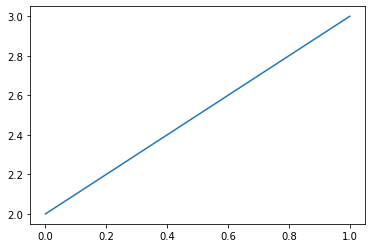

In [29]:
# Run the function
log_run = loging_func.run(
    local=True, handler=handler_name,
)

## Checking the logged artifacts/results

In [30]:
# Extract the artifacts and the runs from the project

artifacts = project.list_artifacts()
artifact_keys = [art['metadata']['key'] for art in artifacts]

runs = project.list_runs()
results = runs[0]['status']['results']

In [31]:
handler_name = handler_name.replace("_", "-")
artifact_prefix = function_name + "-" + handler_name + "_"

assert artifacts
assert len(artifacts)==11

for key in artifact_keys:
    # Check artifacts from the project exist in the run outputs
    assert key in log_run.outputs.keys()
    
    # Now checks the values are the same (store uri)
    artifact_uri = project.get_artifact(key=artifact_prefix+key).uri
    artifact_uri = remove_iter_from_uri(artifact_uri)
    assert artifact_uri==log_run.outputs[key]
    
# Check the logged results (metrics)
for result in results.keys():
    assert result in log_run.outputs.keys()
    assert results[result]==log_run.outputs[result]


## Deleting projects and relevant resources

In [32]:
run_db = mlrun.get_run_db()
run_db.delete_project(project_name1, mlrun.common.schemas.constants.DeletionStrategy.cascade)
run_db.delete_project(project_name2, mlrun.common.schemas.constants.DeletionStrategy.cascade)
run_db.delete_project(project_name3, mlrun.common.schemas.constants.DeletionStrategy.cascade)
run_db.delete_project(project_name4, mlrun.common.schemas.constants.DeletionStrategy.cascade)

> 2023-12-07 14:36:49,264 [info] Project is being deleted: {'project_name': 'test-mlflow-tracking1'}
> 2023-12-07 14:36:52,323 [info] Project deleted: {'project_name': 'test-mlflow-tracking1'}
> 2023-12-07 14:36:52,469 [info] Project is being deleted: {'project_name': 'test-mlflow-tracking2'}
> 2023-12-07 14:36:55,526 [info] Project deleted: {'project_name': 'test-mlflow-tracking2'}
> 2023-12-07 14:36:55,659 [info] Project is being deleted: {'project_name': 'test-mlflow-tracking3'}
> 2023-12-07 14:36:58,720 [info] Project deleted: {'project_name': 'test-mlflow-tracking3'}
> 2023-12-07 14:36:58,851 [info] Project is being deleted: {'project_name': 'test-mlflow-tracking4'}
> 2023-12-07 14:37:01,906 [info] Project deleted: {'project_name': 'test-mlflow-tracking4'}


In [33]:
import os
import shutil

files_to_delete = ["training.py", "serving.py", "offline_training.py", "log_stuff.py", "features.txt", "project.yaml"]
for file in files_to_delete:
    os.remove(file)


folder = "test-mlflow-tracking"
try:
    shutil.rmtree(folder)
    print(f"Folder '{folder}' deleted successfully.")
except Exception as e:
        print(f"Error deleting folder: {e}")


Folder 'data' deleted successfully.
Folder 'mlruns' deleted successfully.
